In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
include("src/utils.jl")
include("src/expo_environment.jl")
include("src/raycaster.jl")
include("src/nb_1.jl");

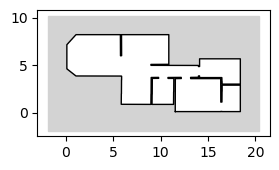

(187, 4)


In [3]:
env = load_env(2010)
println(size(env.segs))
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

# Utilities

In [4]:
"""
    is_valid_move(x, y, env::Env)

Checks if the step from `x` to `y` passes through an 
obstacle, and if so returns a scalar `s`  such that 
`(1-s)*x + s*y` encodes the intersection with the boundary
"""
function is_valid_move(x, y, env::Env)
    v = y - x
    _,C,S,T = ray_coll([x;y], env.segs) 
    if sum(C) == 0
        return true, nothing
    else
        s = min(S[C]...)
        return s > 1., s
    end
end;

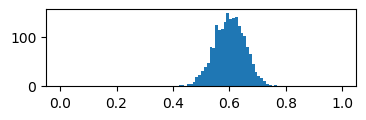

0.6013945072533207

In [5]:
"Beta-like distribution over a bigger interval."
@dist function my_scaled_beta(a, mean, scale)
    mean_beta = mean/scale
    b = a/mean_beta - a
    scale*beta(a,b);
end;

a = 50.
mean_speed = .6
max_speed = 1.

samples = [my_scaled_beta(a, mean_speed, max_speed) for t=1:2000]
plt.figure(figsize=(4,1));
plt.hist(samples, bins=0:max_speed/100:max_speed);
mean(samples)

# Controller- and Transition Model

In [6]:
"""
    Control

Contains the controls of the agent. 
"""
struct Control <: StructIterator
    "speed"
    s::Float64 
    "change of head direction"
    dhd::Float64
end;


"""
    control_prior(mean_speed, max_speed, dhd_noise)

Mindlessly samples a random control vector.
"""
@gen function control_prior(mean_speed, max_speed, dhd_noise)
    s   ~ my_scaled_beta(50., mean_speed, max_speed)
    dhd ~ normal(0, dhd_noise)
    return Control(s, dhd)
end;

In [7]:
"""
    motion_model(pose::Pose, u::Control, hd_noise, x_noise) 

A motion model for an agent that does **not** respect environmental boundaries.
"""
@gen function motion_model(pose::Pose, u::Control, hd_noise, x_noise)    
    hd ~ normal(pose.hd + u.dhd, hd_noise) 
    v = [u.s*cos(hd); u.s*sin(hd)]
    x ~ mvnormal(pose.x + v, Diagonal([x_noise, x_noise]))
    return Pose(x, hd)
end;

# Model w/o Mapping 

In [8]:
@gen (static) function localization_kernel(t::Int, 
                          pose::Pose, 
                          env::Env, 
                          control_args,
                          transition_args,
                          sensor_args)

    mean_speed, max_speed, dhd_noise = control_args
    hd_noise, x_noise                = transition_args
    fov, n, a_noise, z_noise, max_z  = sensor_args
    
    u     = @trace(control_prior(mean_speed, max_speed, dhd_noise), :u)
    pose  = @trace(motion_model(pose, u, hd_noise, x_noise), :pose)
    s     = @trace(sensor_model(pose, env, fov, n, a_noise, z_noise, max_z), :sense)
    
    return pose
end

loc_chain = Gen.Unfold(localization_kernel);
Gen.load_generated_functions();

In [9]:
function draw_tr!(tr, t=nothing; ax=plt.gca())
    T,_,env = get_args(tr)
    p = [tr[t => :pose] for t=1:T]
    x = hcat(map((q)->q.x, p)...)
    hd = map((q)->q.hd, p)
    s = [tr[t => :sense] for t=1:T]
    
    ax.set_aspect(1); ax.axis("off")
    draw_env!(env)
    ax.plot(x[1,:], x[2,:], marker=".", alpha=0.5)
    if t != nothing
        draw_pose!(p[t], ax=ax)
        draw_sense!(s[t], p[t], ax=ax, s= 10) 
    end
end

draw_tr! (generic function with 2 methods)

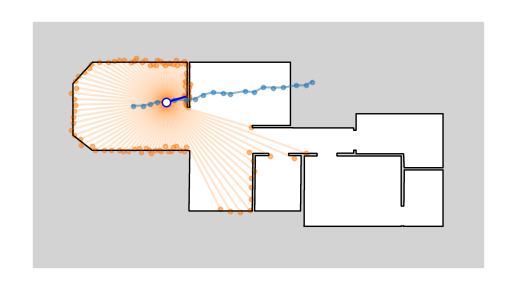

PyObject <matplotlib.collections.PathCollection object at 0x7fd9b4370050>

In [10]:
# Config
# ---
T = 20
control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.01, x_noise=0.01)
sensor_args  = (fov=180, n=100, a_noise=1e-5, z_noise=1e-2, max_z=30.)


# Initial state of the chain
# ---
p0 = Pose([2.5; 6.], -0.1)

tr = Gen.simulate(loc_chain, (T,p0,env,control_args, motion_args, sensor_args));
ch = get_choices(tr);
draw_tr!(tr,5)

# Inference

In [11]:
data = load("example_sensor_data.jld")

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Dict{String,Any} with 10 entries:
  "n"       => 100
  "s"       => [1.0, 1.0, 0.322577, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.010952…
  "fov"     => 180
  "hd"      => [-0.992181, -0.992181, -0.992181, -0.992181, -0.0614746, -0.0614…
  "env_id"  => 2010
  "x"       => [4.69786 6.46749; 5.24472 5.63027; … ; 13.336 2.12974; 13.4505 1…
  "z"       => Any[[2.09324, 2.18727, 2.29964, 2.43431, 2.59662, 2.79394, 3.036…
  "a"       => Any[[-3.14159, -3.07876, -3.01593, -2.9531, -2.89027, -2.82743, …
  "dhd"     => [0.0, -7.77156e-16, 5.55112e-16, 0.930706, 0.0, 5.55112e-17, 0.0…
  "max_val" => Inf

In [12]:
include("src/data_utils.jl")

env_id = data["env_id"]
env = load_env(env_id; path=p"data/HouseExpo_json");
fov, n, max_val = extract_sensor_args(data)
ps = extract_poses(data)
xs = hcat([p.x for p in ps]...)
us = extract_controls(data)
ss = extract_measurements(data)

T = length(us)
println(size(ps), size(us), size(sen))

# -------
plt.figure(figsize=(5,5)); plt.gca().set_aspect(1.);
plt.title("True poses of the agent")
draw_env!(env);
# plt.plot(xs[1,:], xs[2,:], marker=".", alpha=0.5);
for p in ps
    draw_pose!(p)
end

UndefVarError: UndefVarError: sen not defined

In [13]:
function set_z!(ch, z, t)
    ch[t => :sense => :z] = z
end

function set_u!(ch, u, t)
    ch[t => :u => :s] = u.s
    ch[t => :u => :dhd] = u.dhd
end

function set_p!(ch, p, t)
    ch[t => :pose => :x]  = p.x
    ch[t => :pose => :hd] = p.hd;
end;

## MH Inference

t: 1...  3.930733 seconds (7.00 M allocations: 1022.794 MiB, 7.33% gc time)
t: 2...  0.483035 seconds (806.51 k allocations: 710.614 MiB, 36.56% gc time)
t: 3...  0.521567 seconds (806.42 k allocations: 710.607 MiB, 41.22% gc time)
t: 4...  0.470795 seconds (808.82 k allocations: 710.670 MiB, 38.51% gc time)
t: 5...  0.505092 seconds (812.10 k allocations: 710.744 MiB, 34.87% gc time)
t: 6...  0.516507 seconds (822.71 k allocations: 710.958 MiB, 35.44% gc time)
t: 7...  0.438881 seconds (826.03 k allocations: 711.034 MiB, 33.27% gc time)
t: 8...  0.501717 seconds (818.50 k allocations: 710.737 MiB, 36.26% gc time)
t: 9...  0.532892 seconds (811.02 k allocations: 710.510 MiB, 36.81% gc time)
t: 10...  0.484683 seconds (808.62 k allocations: 710.447 MiB, 33.28% gc time)
t: 11...  0.555475 seconds (813.27 k allocations: 710.580 MiB, 35.29% gc time)
t: 12...  0.530492 seconds (818.50 k allocations: 710.811 MiB, 33.11% gc time)
t: 13...  0.513920 seconds (828.29 k allocations: 711.082 MiB, 

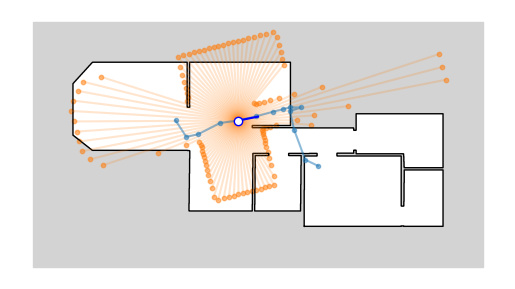

 0.567244 seconds (838.96 k allocations: 711.292 MiB, 35.57% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x7fd9b2327bd0>

In [14]:
# Config
# ---

control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=100, a_noise=1e-5, z_noise=1e-1, max_z=30.)

p = ps[1]

# Initial trace
tr, = Gen.generate(loc_chain, (0, p, env, control_args, motion_args, sensor_args), choicemap());



hist = []

for t=1:T
    global tr;
    
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, ss[t+1].z, t)
    
    
    print("t: $(t)...")
    @time begin
        new_args = (t, p, env, control_args, motion_args, sensor_args)
        argdiffs = changes([1,0,0,0,0,0])
        tr, _,_,_  = update(tr, new_args, argdiffs, new_obs)


        for i=1:100
            tr, = mh(tr, select(t => :pose)) 
        end
    end
    
#     push!(hist, (tr, M))
        
end


draw_tr!(tr,5)

## Incremental Inference

In [15]:
function my_incremental_sampling(tr, args, diffs, selection, new_obs, num)
    
    tr,w = update(tr, args, diffs, new_obs)
    

    diffs = changes(zeros(length(args)))
    
    trs = []
    ws = []
    for i=1:num
        tr′, w′ = regenerate(tr, args, diffs, selection)
        push!(trs, tr′)
        push!(ws, w′)
    end
    return trs, ws
end;



t: 1...  0.696626 seconds (1.01 M allocations: 720.639 MiB, 30.69% gc time)
t: 2...  0.485281 seconds (805.12 k allocations: 710.492 MiB, 31.21% gc time)
t: 3...  0.551542 seconds (805.42 k allocations: 710.501 MiB, 37.99% gc time)
t: 4...  0.553093 seconds (807.97 k allocations: 710.555 MiB, 39.73% gc time)
t: 5...  0.538707 seconds (810.56 k allocations: 710.615 MiB, 35.89% gc time)
t: 6...  0.532098 seconds (813.62 k allocations: 710.684 MiB, 37.86% gc time)
t: 7...  0.517659 seconds (822.25 k allocations: 710.864 MiB, 34.16% gc time)
t: 8...  0.525640 seconds (823.27 k allocations: 710.879 MiB, 36.34% gc time)
t: 9...  0.556797 seconds (824.51 k allocations: 710.907 MiB, 38.67% gc time)
t: 10...  0.551795 seconds (834.67 k allocations: 711.106 MiB, 39.29% gc time)
t: 11...  0.556084 seconds (835.03 k allocations: 711.115 MiB, 38.53% gc time)
t: 12...  0.498224 seconds (833.02 k allocations: 711.074 MiB, 33.93% gc time)
t: 13...  0.523238 seconds (829.25 k allocations: 711.002 MiB, 

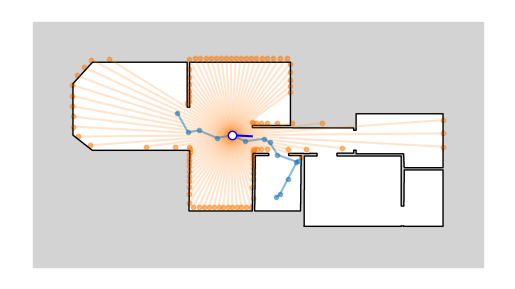

  0.540590 seconds (824.44 k allocations: 710.865 MiB, 37.51% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x7fd9b25a9510>

In [16]:
# Config
# ---

control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=100, a_noise=1e-5, z_noise=1e-1, max_z=30.)

p = ps[1]

# Initial trace
tr, = Gen.generate(loc_chain, (0, p, env, control_args, motion_args, sensor_args), choicemap());



hist = []

for t=1:T
    global tr;
    
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, ss[t+1].z, t)
    
    

    new_args = (t, p, env, control_args, motion_args, sensor_args)
    argdiffs = changes([1,0,0,0,0,0])

    print("t: $(t)...")
    @time begin
    trs, ws = my_incremental_sampling(tr, new_args, argdiffs, select(t => :pose), new_obs, 100)
    end
    tr = trs[argmax(ws)]
        
end


draw_tr!(tr,5)

# Loosen Sensor

In [17]:
sensor_mixture = HeterogeneousMixture([normal; uniform])

struct MultivariateSensor <: Gen.Distribution{Vector{Float64}} end
const mvsensor = MultivariateSensor()

function Gen.logpdf(::MultivariateSensor, z::AbstractArray{Float64,1}, 
                    mu::AbstractArray{Float64,1}, sig::Float64, max_val::Float64, w::Float64)
    
    n = length(mu)
    f = map((i) -> Gen.logpdf(sensor_mixture, z[i], [1.0-w, w], mu[i], sig, 0.0, max_val), 1:n)
    f = sum(f)
    return f
end

function Gen.random(::MultivariateSensor, 
                    mu::AbstractArray{Float64,1}, 
                    sig::Float64, 
                    max_val::Float64, 
                    w::Float64)
    n = length(mu)
    z = [sensor_mixture([1.0-w, w], mu[i], sig, 0.0, max_val) for i=1:n]
    return z
end

(::MultivariateSensor)(mu::AbstractArray{Float64,1}, 
                       sig::Float64, 
                       max_val::Float64, 
                       w::Float64) = Gen.random(MultivariateSensor(), mu, sig, max_val, w)

Gen.has_output_grad(::MultivariateSensor) = false;
Gen.has_argument_grads(::MultivariateSensor) = (false,false,false,false);

In [18]:
@gen function sensor_model_loosened(pose::Pose, env::Env, fov, n, z_noise, max_z, drop_out)
    x, hd = pose
    
    a0 = angles(fov, n)
    a = a0 .+ hd 
    z0 = cast(lightcone(a), x, env.segs; max_val=max_z)
    z  = @trace(mvsensor(z0, z_noise, max_z, drop_out), :z)
    
    return Measurement(z, a0)
end;

In [19]:
@gen (static) function new_localization_kernel(t::Int, 
                          pose::Pose, 
                          env::Env, 
                          control_args,
                          transition_args,
                          sensor_args, drop_out)

    mean_speed, max_speed, dhd_noise = control_args
    hd_noise, x_noise                = transition_args
    fov, n, z_noise, max_z  = sensor_args
    
    u     = @trace(control_prior(mean_speed, max_speed, dhd_noise), :u)
    pose  = @trace(motion_model(pose, u, hd_noise, x_noise), :pose)
    s     = @trace(sensor_model_loosened(pose, env, fov, n, z_noise, max_z, drop_out), :sense)
    
    return pose
end

new_loc_chain = Gen.Unfold(new_localization_kernel);
Gen.load_generated_functions();

# New Inference

t: 1...  1.710604 seconds (4.19 M allocations: 829.801 MiB, 10.94% gc time)
t: 2...  0.323894 seconds (1.17 M allocations: 674.645 MiB, 42.51% gc time)
t: 3...  0.315419 seconds (1.17 M allocations: 674.659 MiB, 38.80% gc time)
t: 4...  0.347641 seconds (1.17 M allocations: 674.692 MiB, 42.60% gc time)
t: 5...  0.311486 seconds (1.17 M allocations: 674.746 MiB, 42.58% gc time)
t: 6...  0.318935 seconds (1.17 M allocations: 674.816 MiB, 39.94% gc time)
t: 7...  0.335414 seconds (1.18 M allocations: 675.007 MiB, 42.89% gc time)
t: 8...  0.344522 seconds (1.18 M allocations: 675.024 MiB, 41.14% gc time)
t: 9...  0.338165 seconds (1.19 M allocations: 675.072 MiB, 39.62% gc time)
t: 10...  0.335496 seconds (1.18 M allocations: 675.056 MiB, 42.73% gc time)
t: 11...  0.328517 seconds (1.19 M allocations: 675.076 MiB, 40.56% gc time)
t: 12...  0.350201 seconds (1.18 M allocations: 675.048 MiB, 42.44% gc time)
t: 13...  0.341515 seconds (1.18 M allocations: 675.053 MiB, 39.87% gc time)
t: 14...

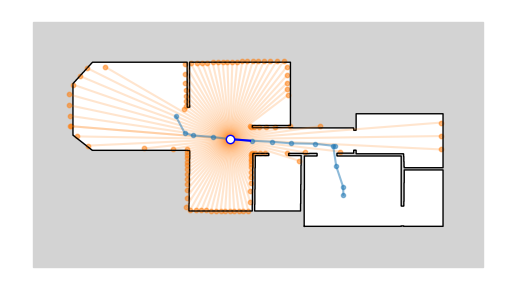

  0.326761 seconds (1.18 M allocations: 675.019 MiB, 39.73% gc time)


PyObject <matplotlib.collections.PathCollection object at 0x7fd9ce7c5d10>

In [20]:
# Config
# ---

control_args = (mean_speed=.5, max_speed=1., dhd_noise=0.1)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=100, z_noise=1e-1, max_z=30.)
drop_out = 0.2
p = ps[1]

# Initial trace
tr, = Gen.generate(new_loc_chain, (0, p, env, control_args, motion_args, sensor_args, drop_out), choicemap());


for t=1:T
    global tr;
    
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, ss[t+1].z, t)
    
    

    new_args = (t, p, env, control_args, motion_args, sensor_args, drop_out)
    argdiffs = changes([1,0,0,0,0,0])

    print("t: $(t)...")
    @time begin
    trs, ws = my_incremental_sampling(tr, new_args, argdiffs, select(t => :pose), new_obs, 100)
    end
    tr = trs[argmax(ws)]
        
end


draw_tr!(tr, 5)

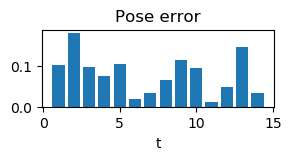

In [21]:
err = [norm(ps[t+1].x - tr[t => :pose => :x]) for t=1:T]
plt.figure(figsize=(3,1));
plt.title("Pose error"); plt.xlabel("t")
plt.bar(1:T, err);